# Time Series and Deep Learning

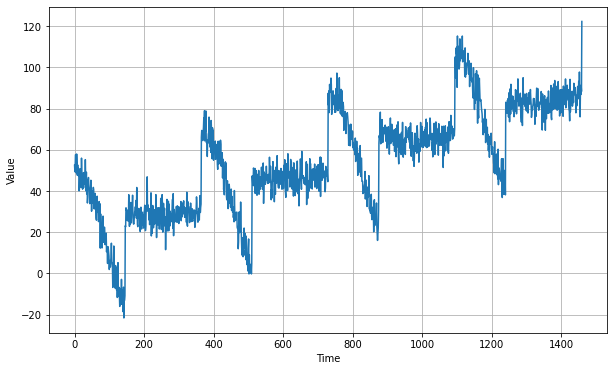

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Preparing features and labels

In [0]:
# dataset = tf.data.Dataset.range(10)
# for val in dataset:
#   print(val.numpy())

# dataset = dataset.window(5, shift=1)
# for window_dataset in dataset:
#   for val in window_dataset:
#     print(val.numpy(), end=" ")
#   print()

# dataset = dataset.window(5, shift=1, drop_remainder=True)
# for window_dataset in dataset:
#   for val in window_dataset:
#     print(val.numpy(), end=" ")
#   print()

# dataset = dataset.window(5, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window:window.batch(5))
# for window in dataset:
#   print(window.numpy())

# Split the data
# dataset = dataset.window(5, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window:window.batch(5))
# dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
# for x,y in dataset:
#   print(x.numpy(), y.numpy())

#Shuffle
# dataset = dataset.window(5, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window:window.batch(5))
# dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
# dataset = dataset.shuffle(buffer_size = 10)
# for x,y in dataset:
#   print(x.numpy(), y.numpy())

#Batch the data
# dataset = dataset.window(5, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window:window.batch(5))
# dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
# dataset = dataset.shuffle(buffer_size = 10)
# dataset = dataset.batch(2).prefetch(1)
# for x,y in dataset:
#   print(x.numpy())
#   print(y.numpy())

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset = dataset.shuffle(buffer_size = shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# Train Neural Network

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [40]:
window_size = 20
batch_size= 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

In [41]:
print(l0.get_weights())

[array([[-0.0177478 ],
       [-0.00090524],
       [ 0.02622141],
       [-0.04039279],
       [ 0.04994611],
       [-0.00984743],
       [-0.05170834],
       [ 0.04806694],
       [ 0.0248356 ],
       [-0.04285297],
       [ 0.01212999],
       [ 0.03478713],
       [-0.02872385],
       [ 0.02139875],
       [ 0.00744939],
       [ 0.05070827],
       [ 0.06473786],
       [ 0.19590348],
       [ 0.2452053 ],
       [ 0.4252846 ]], dtype=float32), array([0.01722612], dtype=float32)]


## Get Prediction

In [43]:
print(series[1:21])
print()
model.predict(series[1:21][np.newaxis])

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]



array([[49.98143]], dtype=float32)

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

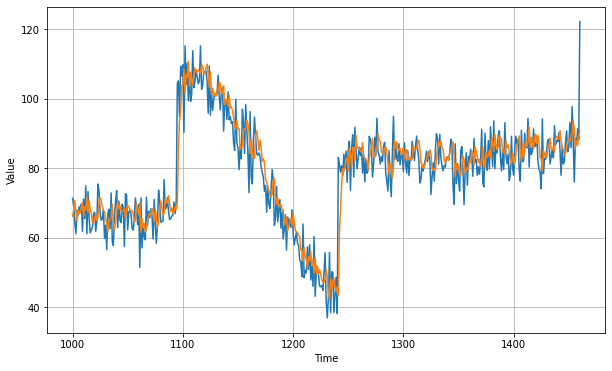

In [46]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

## Evaluate

In [45]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0066743

# More on single layer neural network: DNN

In [48]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

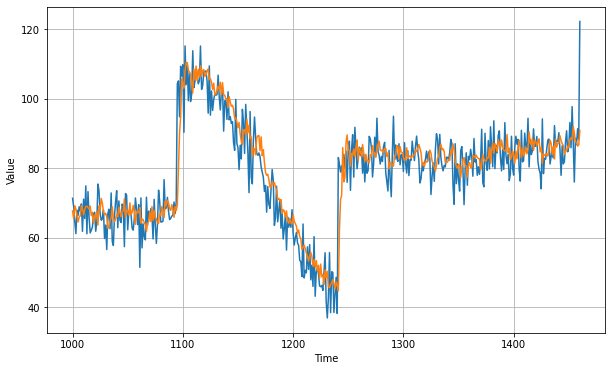

In [50]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [51]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9101987

## Comment

But it's also a somewhat a stab in the dark, particularly with the optimizer function. Wouldn't it be nice if we could pick the optimal learning rate instead of the one that we chose? We might learn more efficiently and build a better model. Now let's look at a technique for that that uses callbacks


You can see that code here. This will be called at the callback at the end of each epoch. What it will do is change the learning rates to a value based on the epoch number. So in epoch 1, it is 1 times 10 to the -8 times 10 to the power of 1 over 20. And by the time we reach the 100 epoch, it'll be 1 times 10 to the -8 times 10 to the power of 5, and that's 100 over 20. This will happen on each callback because we set it in the callbacks parameter of modeled outfit.

In [53]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
46/46 [==============================] - 0s 3ms/step - loss: 44.2379 - lr: 1.0000e-08
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 43.4713 - lr: 1.1220e-08
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 43.2286 - lr: 1.2589e-08
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 43.1769 - lr: 1.4125e-08
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 43.1783 - lr: 1.5849e-08
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 43.1688 - lr: 1.7783e-08
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 43.1543 - lr: 1.9953e-08
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 43.1823 - lr: 2.2387e-08
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 43.1594 - lr: 2.5119e-08
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 43.1923 - lr: 2.8184e-08
Epoch 11/100
46/46 

(1e-08, 0.001, 0.0, 300.0)

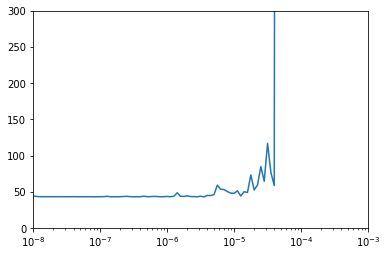

In [60]:
# We can then plot the last per epoch against the learning rate per epoch

lrs = 1e-8 * (10 **(np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

## Comment

The y-axis shows us the loss for that epoch and the x-axis shows us the learning rate. We can then try to pick the lowest point of the curve where it's still relatively stable like this, and that's right around 7 times 10 to the -6.

By the way, let's update it based on learning rate plot

In [67]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9), metrics=['accuracy'])
history = model.fit(dataset, epochs=500)

Epoch 1/500
46/46 [==============================] - 0s 2ms/step - loss: 592.3976 - accuracy: 0.0000e+00
Epoch 2/500
46/46 [==============================] - 0s 3ms/step - loss: 82.5001 - accuracy: 0.0000e+00
Epoch 3/500
46/46 [==============================] - 0s 3ms/step - loss: 76.6137 - accuracy: 0.0000e+00
Epoch 4/500
46/46 [==============================] - 0s 3ms/step - loss: 56.6367 - accuracy: 0.0000e+00
Epoch 5/500
46/46 [==============================] - 0s 3ms/step - loss: 69.5052 - accuracy: 0.0000e+00
Epoch 6/500
46/46 [==============================] - 0s 3ms/step - loss: 57.6221 - accuracy: 0.0000e+00
Epoch 7/500
46/46 [==============================] - 0s 3ms/step - loss: 57.4962 - accuracy: 0.0000e+00
Epoch 8/500
46/46 [==============================] - 0s 3ms/step - loss: 51.5005 - accuracy: 0.0000e+00
Epoch 9/500
46/46 [==============================] - 0s 3ms/step - loss: 52.4526 - accuracy: 0.0000e+00
Epoch 10/500
46/46 [==============================] - 0s 3ms/st

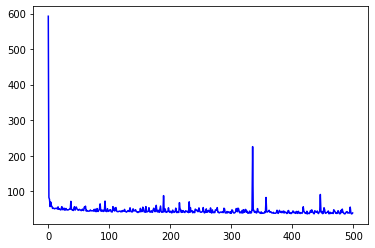

In [71]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training')

## Comment

Which upon first inspection looks like we're probably wasting our time training beyond maybe only 10 epochs, but it's somewhat skewed by the fact that the earlier losses were so high. If we cropped them off and plot the loss for epochs after number 10 with code like this, then the chart will tell us a different story.

[50.396183013916016, 51.162235260009766, 51.87508010864258, 51.52235794067383, 52.272125244140625, 49.75364303588867, 55.97123336791992, 49.04679870605469, 50.51765441894531, 49.30214309692383, 47.39644241333008, 47.900569915771484, 56.42401123046875, 54.49580764770508, 47.51862716674805, 49.15546798706055, 52.0787467956543, 46.65906524658203, 47.192935943603516, 51.30533218383789, 47.69471740722656, 47.62799835205078, 46.90265655517578, 47.68614959716797, 48.62971496582031, 49.4550666809082, 49.46829605102539, 71.43338012695312, 49.41295623779297, 47.2989616394043, 47.79835891723633, 45.7043342590332, 52.34226608276367, 56.52084732055664, 46.70420455932617, 53.26173782348633, 55.38375473022461, 49.55180358886719, 48.80171585083008, 46.178035736083984, 47.32977294921875, 48.90340805053711, 47.918113708496094, 46.699459075927734, 45.21681594848633, 46.782752990722656, 49.574893951416016, 46.3740348815918, 45.538665771484375, 55.35904312133789, 53.710182189941406, 57.93363571166992, 44.4

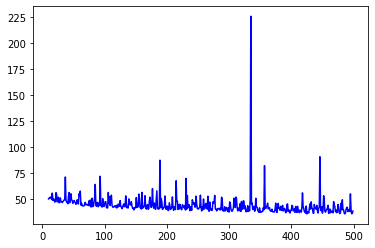

In [72]:
loss = history.history['loss']
epochs = range(10, len(acc))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

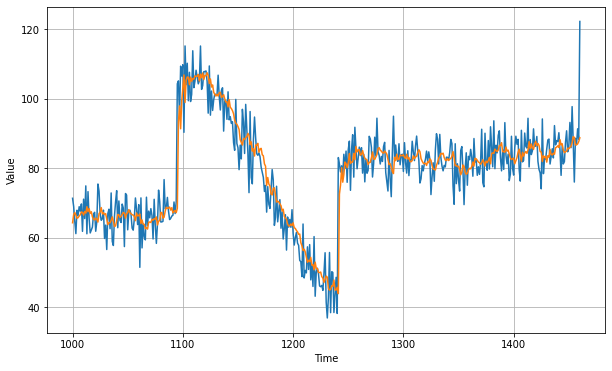

In [73]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [74]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.5761485

## Comment

Using a very simple DNN, we've improved our results very nicely. But it's still just a DNN, there's no sequencing taken into account, and in a time series like this, the values that are immediately before a value are more likely to impact it than those further in the past. And that's the perfect set up to use RNS like we had in the natural language course.

# Recurrent Neural Network

In [0]:
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [97]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.SimpleRNN(40, return_sequences=True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x:x*100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
46/46 [==============================] - 0s 8ms/step - loss: 121.9703 - mae: 122.4702 - lr: 1.0000e-08
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: 117.2720 - mae: 117.7710 - lr: 1.1220e-08
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 111.8150 - mae: 112.3147 - lr: 1.2589e-08
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 105.7018 - mae: 106.2017 - lr: 1.4125e-08
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: 98.9282 - mae: 99.4282 - lr: 1.5849e-08
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: 91.4383 - mae: 91.9381 - lr: 1.7783e-08
Epoch 7/100
46/46 [==============================] - 0s 9ms/step - loss: 83.2251 - mae: 83.7251 - lr: 1.9953e-08
Epoch 8/100
46/46 [==============================] - 0s 8ms/step - loss: 74.1881 - mae: 74.6879 - lr: 2.2387e-08
Epoch 9/100
46/46 [==============================] - 0s 8ms/step - loss: 64.4240 - mae: 

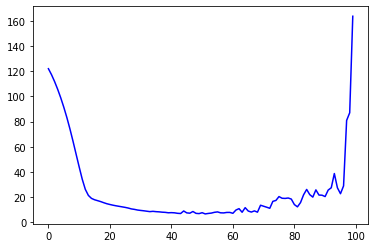

In [98]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training')

(1e-08, 0.001, 0.0, 300.0)

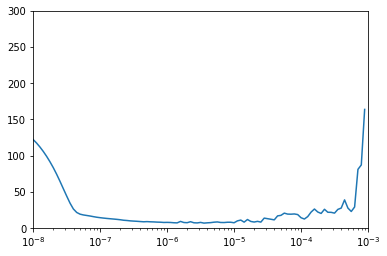

In [99]:
lrs = 1e-8 * (10 **(np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

## Based on learning rate plot...

In [100]:
optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=70, callbacks=[lr_schedule])

Epoch 1/70
46/46 [==============================] - 0s 8ms/step - loss: 49.0089 - mae: 49.5080 - lr: 1.0000e-08
Epoch 2/70
46/46 [==============================] - 0s 8ms/step - loss: 47.3267 - mae: 47.8261 - lr: 1.1220e-08
Epoch 3/70
46/46 [==============================] - 0s 8ms/step - loss: 45.3952 - mae: 45.8946 - lr: 1.2589e-08
Epoch 4/70
46/46 [==============================] - 0s 8ms/step - loss: 43.2638 - mae: 43.7622 - lr: 1.4125e-08
Epoch 5/70
46/46 [==============================] - 0s 8ms/step - loss: 40.9476 - mae: 41.4473 - lr: 1.5849e-08
Epoch 6/70
46/46 [==============================] - 0s 8ms/step - loss: 38.4183 - mae: 38.9170 - lr: 1.7783e-08
Epoch 7/70
46/46 [==============================] - 0s 8ms/step - loss: 35.6857 - mae: 36.1846 - lr: 1.9953e-08
Epoch 8/70
46/46 [==============================] - 0s 8ms/step - loss: 32.8303 - mae: 33.3263 - lr: 2.2387e-08
Epoch 9/70
46/46 [==============================] - 0s 8ms/step - loss: 30.1089 - mae: 30.6044 - lr: 2.5

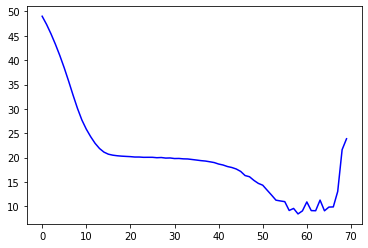

In [101]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training')

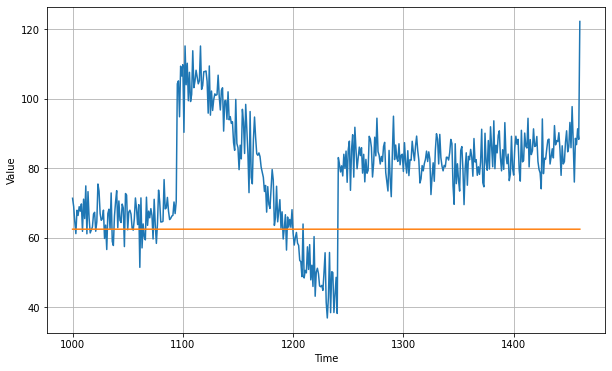

In [102]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [103]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

18.428162

# LSTMs

In [0]:
tf.keras.backend.clear_session()

In [107]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x:x*100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss='mae', optimizer=optimizer)
history = model.fit(dataset, epochs=100)

Epoch 1/100
46/46 [==============================] - 1s 12ms/step - loss: 14.5851
Epoch 2/100
46/46 [==============================] - 1s 12ms/step - loss: 7.7686
Epoch 3/100
46/46 [==============================] - 1s 12ms/step - loss: 7.0276
Epoch 4/100
46/46 [==============================] - 1s 12ms/step - loss: 6.8860
Epoch 5/100
46/46 [==============================] - 1s 12ms/step - loss: 6.7553
Epoch 6/100
46/46 [==============================] - 1s 12ms/step - loss: 6.5553
Epoch 7/100
46/46 [==============================] - 1s 12ms/step - loss: 6.4627
Epoch 8/100
46/46 [==============================] - 1s 12ms/step - loss: 6.5194
Epoch 9/100
46/46 [==============================] - 1s 13ms/step - loss: 6.3709
Epoch 10/100
46/46 [==============================] - 1s 13ms/step - loss: 6.2503
Epoch 11/100
46/46 [==============================] - 1s 12ms/step - loss: 6.2338
Epoch 12/100
46/46 [==============================] - 1s 12ms/step - loss: 6.2476
Epoch 13/100
46/46 [====

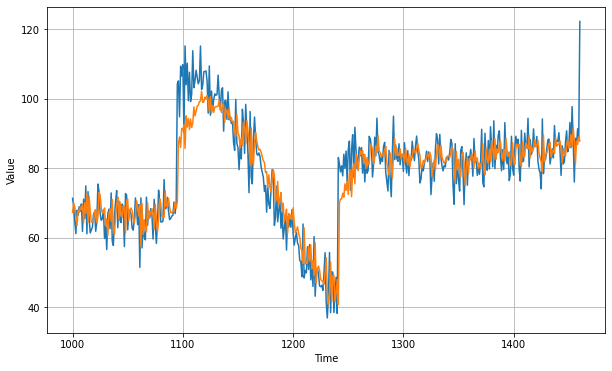

In [108]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [109]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.479661

In [110]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x:x*100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss='mae', optimizer=optimizer)
history = model.fit(dataset, epochs=100)

Epoch 1/100
46/46 [==============================] - 1s 25ms/step - loss: 29.6398
Epoch 2/100
46/46 [==============================] - 1s 25ms/step - loss: 12.9423
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 9.9412
Epoch 4/100
46/46 [==============================] - 1s 24ms/step - loss: 8.7462
Epoch 5/100
46/46 [==============================] - 1s 24ms/step - loss: 8.3006
Epoch 6/100
46/46 [==============================] - 1s 25ms/step - loss: 7.9468
Epoch 7/100
46/46 [==============================] - 1s 24ms/step - loss: 7.7409
Epoch 8/100
46/46 [==============================] - 1s 25ms/step - loss: 7.5120
Epoch 9/100
46/46 [==============================] - 1s 24ms/step - loss: 7.2830
Epoch 10/100
46/46 [==============================] - 1s 24ms/step - loss: 7.1879
Epoch 11/100
46/46 [==============================] - 1s 25ms/step - loss: 7.3086
Epoch 12/100
46/46 [==============================] - 1s 25ms/step - loss: 7.1999
Epoch 13/100
46/46 [===

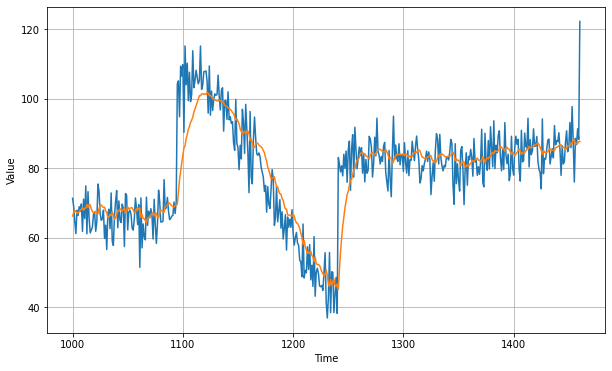

In [111]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [112]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.4769835

In [113]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x:x*100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss='mae', optimizer=optimizer)
history = model.fit(dataset, epochs=100)

Epoch 1/100
46/46 [==============================] - 2s 33ms/step - loss: 21.4928
Epoch 2/100
46/46 [==============================] - 1s 32ms/step - loss: 13.9273
Epoch 3/100
46/46 [==============================] - 1s 32ms/step - loss: 10.1068
Epoch 4/100
46/46 [==============================] - 1s 32ms/step - loss: 9.0096
Epoch 5/100
46/46 [==============================] - 1s 32ms/step - loss: 7.9016
Epoch 6/100
46/46 [==============================] - 1s 31ms/step - loss: 7.7618
Epoch 7/100
46/46 [==============================] - 1s 32ms/step - loss: 7.1565
Epoch 8/100
46/46 [==============================] - 1s 33ms/step - loss: 6.9044
Epoch 9/100
46/46 [==============================] - 1s 32ms/step - loss: 6.7106
Epoch 10/100
46/46 [==============================] - 1s 32ms/step - loss: 6.5815
Epoch 11/100
46/46 [==============================] - 1s 31ms/step - loss: 6.4675
Epoch 12/100
46/46 [==============================] - 1s 32ms/step - loss: 6.4364
Epoch 13/100
46/46 [==

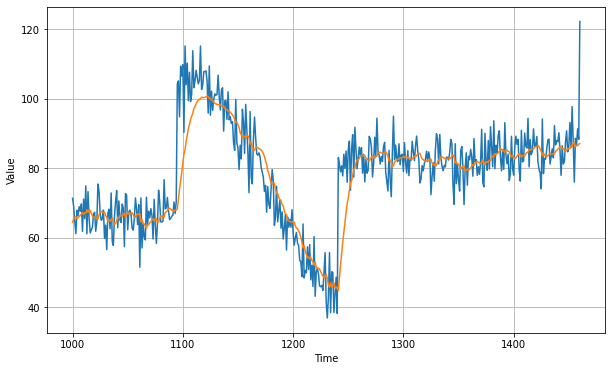

In [114]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# CNN

# Combine all

